In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
from tensorflow.python.ops import array_ops as array_ops_
import matplotlib.pyplot as plt
learn = tf.contrib.learn

#### 1. 设置神经网络的参数。

In [2]:
HIDDEN_SIZE = 30
NUM_LAYERS = 2

TIMESTEPS = 10
TRAINING_STEPS = 3000
BATCH_SIZE = 32

TRAINING_EXAMPLES = 10000
TESTING_EXAMPLES = 1000
SAMPLE_GAP = 0.01

#### 2. 定义生成正弦数据的函数。

In [3]:
def generate_data(seq):
    X = []
    y = []

    for i in range(len(seq) - TIMESTEPS - 1):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

#### 3. 定义lstm模型。

In [4]:
def lstm_model(X, y):
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
    cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * NUM_LAYERS)
    x_ = tf.unpack(X, axis=1)

    output, _ = tf.nn.rnn(cell, x_, dtype=tf.float32)
    output = output[-1]
    
    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构。
    predictions = tf.contrib.layers.fully_connected(output, 1, None)
    predictions = array_ops_.squeeze(predictions, squeeze_dims=[1])
    loss = tf.contrib.losses.mean_squared_error(predictions, y)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)

    return predictions, loss, train_op

#### 4. 进行训练。

In [5]:
# 封装之前定义的lstm。
regressor = SKCompat(learn.Estimator(model_fn=lstm_model,model_dir="Models/model_2"))

# 生成数据。
test_start = TRAINING_EXAMPLES * SAMPLE_GAP
test_end = (TRAINING_EXAMPLES + TESTING_EXAMPLES) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES, dtype=np.float32)))

# 拟合数据。
regressor.fit(train_X, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

# 计算预测值。
predicted = [[pred] for pred in regressor.predict(test_X)]

# 计算MSE。
rmse = np.sqrt(((predicted - test_y) ** 2).mean(axis=0))
print ("Mean Square Error is: %f" % rmse[0])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'save_summary_steps': 100, '_num_ps_replicas': 0, '_task_type': None, '_environment': 'local', '_is_chief': True, 'save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1099f2f50>, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, 'tf_random_seed': None, 'keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', 'save_checkpoints_steps': None, '_master': '', 'keep_checkpoint_max': 5}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:loss = 3.94731e-05, step = 3001
INFO:tensorflow:Saving checkpoints for 3001 into Models/model_2/model.ckpt.
INFO:tensorflow:loss = 2.38348e-05, step = 3101
INFO:tensorflow:global_step/sec: 154.849
INFO:tensorflow:loss = 2.27452e-05, step = 3201
INFO:tensorflow:global_step/sec: 537.924
INFO:tensorflow:loss = 2.27922e-05, step = 3301
INFO:tensorflow:global_step/sec: 527.629
INFO:tensorflo

#### 5. 画出预测值和真实值的曲线。

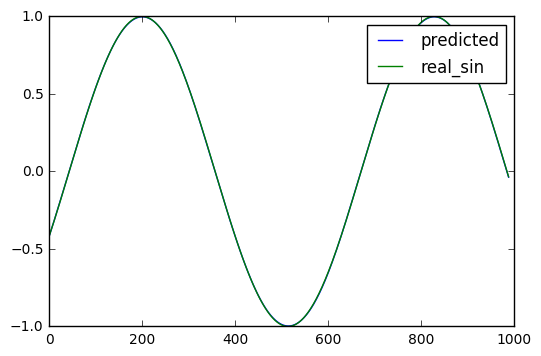

In [6]:
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(test_y, label='real_sin')
plt.legend([plot_predicted, plot_test],['predicted', 'real_sin'])
plt.show()